# Análise de Clusterização — Fase 3 

Isabelle Fernandes de Oliveira

Lucas Dayrell de Andrade Machado  

**Dataset:** Obesity Prediction  (ruchikakumbhar/obesity-prediction)     

## 1. Business Understanding

### 1.1 Objetivo do Dataset

O aumento global nos índices de obesidade tornou-se uma das principais preocupações de saúde pública nas últimas décadas. A obesidade está associada a diversas doenças crônicas, como diabetes tipo 2, hipertensão e problemas cardiovasculares. Com a crescente disponibilidade de dados relacionados a hábitos alimentares e estilos de vida, torna-se possível aplicar técnicas de mineração de dados para identificar padrões relevantes associados ao ganho de peso e perfis de risco.

### 1.2 Origem dos Dados

O dataset “Obesity Prediction” foi disponibilizado no Kaggle pelo pesquisador Ruchika Kumbhar (https://www.kaggle.com/datasets/ruchikakumbhar/obesity-prediction). Ele reúne auto-declarações de hábitos alimentares, níveis de atividade física e dados demográficos de 2.111 voluntários, coletados em estudos de saúde pública realizados entre 2017 e 2019.

### 1.3 Características do Dataset

| Coluna           | Tipo       | Descrição                                                       |
|------------------|------------|-----------------------------------------------------------------|
| Gender           | Categórica | Sexo do indivíduo (“Male” / “Female”).                         |
| Age              | Numérica   | Idade em anos.                                                 |
| Height           | Numérica   | Altura em metros.                                              |
| Weight           | Numérica   | Peso em quilogramas.                                           |
| family_history   | Categórica | Histórico familiar de sobrepeso (“yes” / “no”).                |
| FAVC             | Categórica | Consumo frequente de alimentos calóricos (“yes” / “no”).      |
| FCVC             | Numérica   | Frequência de consumo de vegetais (1 = “never” … 5 = “always”).|
| NCP              | Numérica   | Número de refeições principais por dia.                       |
| CAEC             | Categórica | Consumo de lanches entre refeições (“no” / “sometimes” / …).  |
| SMOKE            | Categórica | Fumante (“yes” / “no”).                                        |
| CH2O             | Numérica   | Litros de água consumidos por dia.                             |
| SCC              | Categórica | Monitoramento diário de ingestão calórica (“yes” / “no”).      |
| FAF              | Numérica   | Frequência de atividade física (1 = “never” … 5 = “always”).   |
| TUE              | Numérica   | Tempo de uso diário de dispositivos tecnológicos (horas).      |
| CALC             | Categórica | Consumo de bebidas alcoólicas (1 = “never” … 5 = “always”).    |
| MTRANS           | Categórica | Meio de transporte habitual (“walking”, “car”, …).             |
| Obesity          | Categórica | Nível de obesidade (rótulo, não utilizado na clusterização).   |

### 1.4 Relação com o Problema de Negócio

A segmentação por clusterização permite:

1. Reconhecer grupos com hábitos de vida que predisponham à obesidade, auxiliando na priorização de políticas de saúde.
2. Direcionar campanhas de nutrição e atividade física a subpopulações com comportamentos semelhantes.
3. Comparar antes/depois em cada grupo para mensurar a eficácia de programas preventivos.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from kmodes.kprototypes import KPrototypes

sns.set_theme(style="whitegrid")


## 2. Data Understanding & Preparation

### 2.1. Exploração Inicial

In [56]:
df = pd.read_csv("Obesity prediction.csv")
df.info()
df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: float64(8), object(9)
memory u

,count,mean,std,min,25%,50%,75%,max
Age,2111.0,24.312600,6.345968,14.00,19.947192,22.777890,26.000000,61.00
Height,2111.0,1.701677,0.093305,1.45,1.630000,1.700499,1.768464,1.98
Weight,2111.0,86.586058,26.191172,39.00,65.473343,83.000000,107.430682,173.00
FCVC,2111.0,2.419043,0.533927,1.00,2.000000,2.385502,3.000000,3.00
NCP,2111.0,2.685628,0.778039,1.00,2.658738,3.000000,3.000000,4.00
CH2O,2111.0,2.008011,0.612953,1.00,1.584812,2.000000,2.477420,3.00
FAF,2111.0,1.010298,0.850592,0.00,0.124505,1.000000,1.666678,3.00
TUE,2111.0,0.657866,0.608927,0.00,0.000000,0.625350,1.000000,2.00


In [57]:
qtde_registro_NA = df.isna().any(axis=1).sum()
print(f"Quantidade de registros com alguma coluna NA: {qtde_registro_NA}")

Quantidade de registros com alguma coluna NA: 0


Como pode ser visto, no dataset não há dados faltantes. Para todas as linhas, todas as colunas estão devidamente preenchidas.
Abaixo, segue a frequência dos registros para cada feature:

In [58]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"\nFrequência da variável '{col}':")
    print(df[col].value_counts())


Frequência da variável 'Gender':
Gender
Male      1068
Female    1043
Name: count, dtype: int64

Frequência da variável 'family_history':
family_history
yes    1726
no      385
Name: count, dtype: int64

Frequência da variável 'FAVC':
FAVC
yes    1866
no      245
Name: count, dtype: int64

Frequência da variável 'CAEC':
CAEC
Sometimes     1765
Frequently     242
Always          53
no              51
Name: count, dtype: int64

Frequência da variável 'SMOKE':
SMOKE
no     2067
yes      44
Name: count, dtype: int64

Frequência da variável 'SCC':
SCC
no     2015
yes      96
Name: count, dtype: int64

Frequência da variável 'CALC':
CALC
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64

Frequência da variável 'MTRANS':
MTRANS
Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: count, dtype: int64

Frequência da variável 'Obesity':
Obesi

### 2.2. Análise Visual

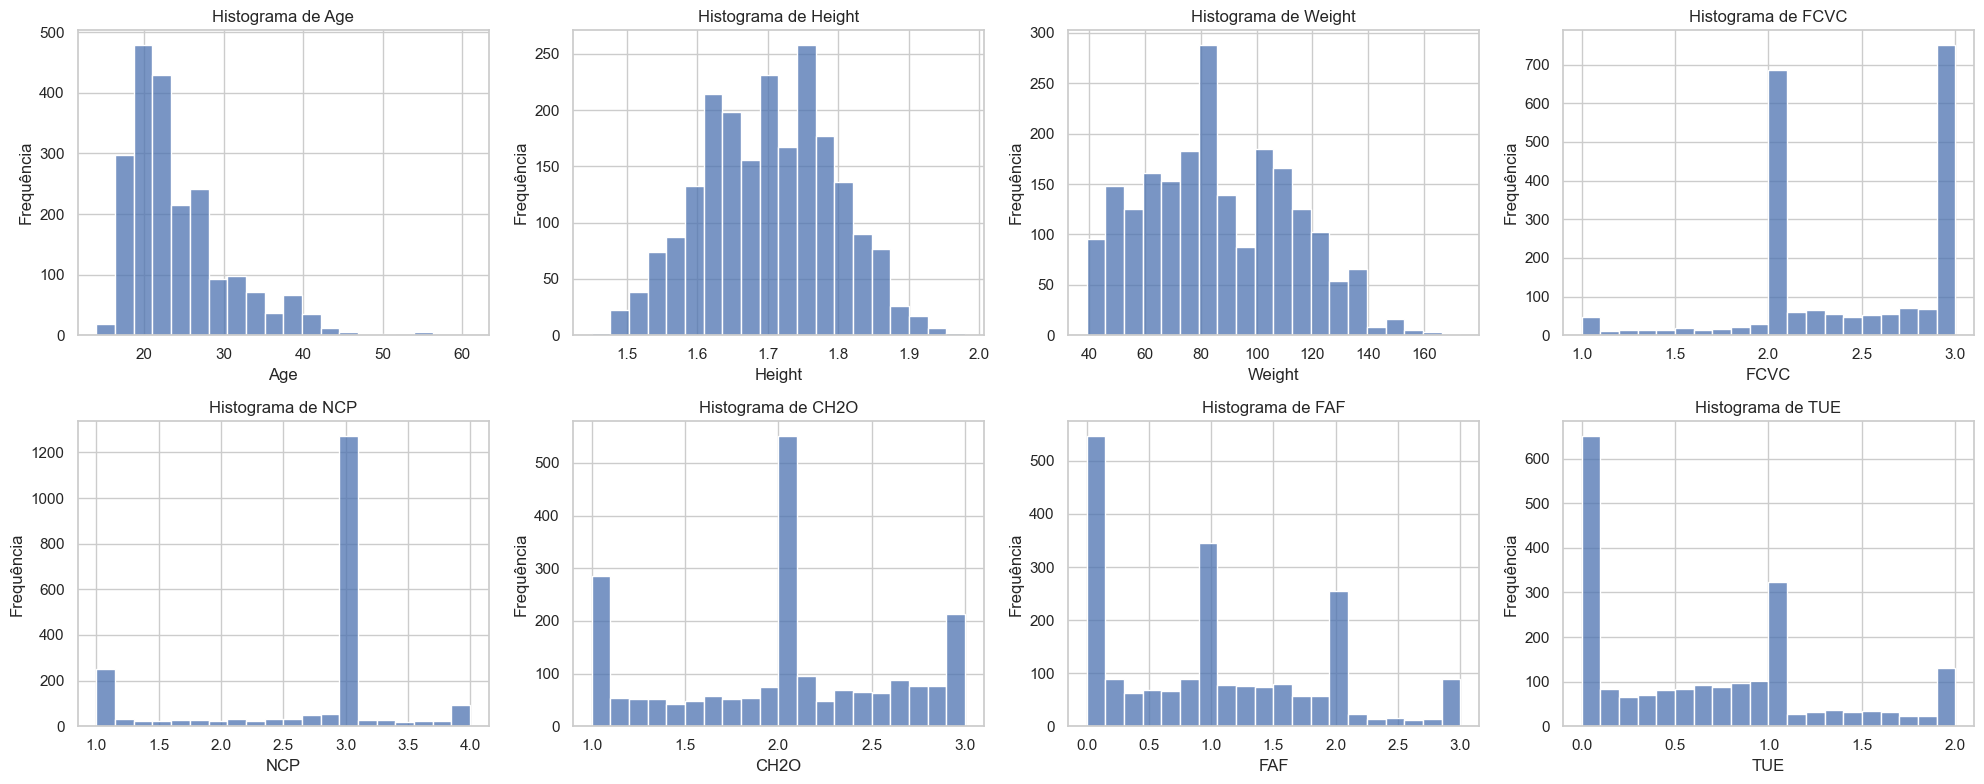

In [59]:
numeric_cols = df.select_dtypes(include='number').columns
num_cols = len(numeric_cols)

# Defina quantas colunas no grid (ex: 3)
cols = 4
rows = (num_cols + cols - 1) // cols  # calcula o número de linhas necessárias

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df, x=col, bins=20, kde=False, ax=axes[i])
    axes[i].set_title(f"Histograma de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequência")

# Remover subplots vazios, se houver
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

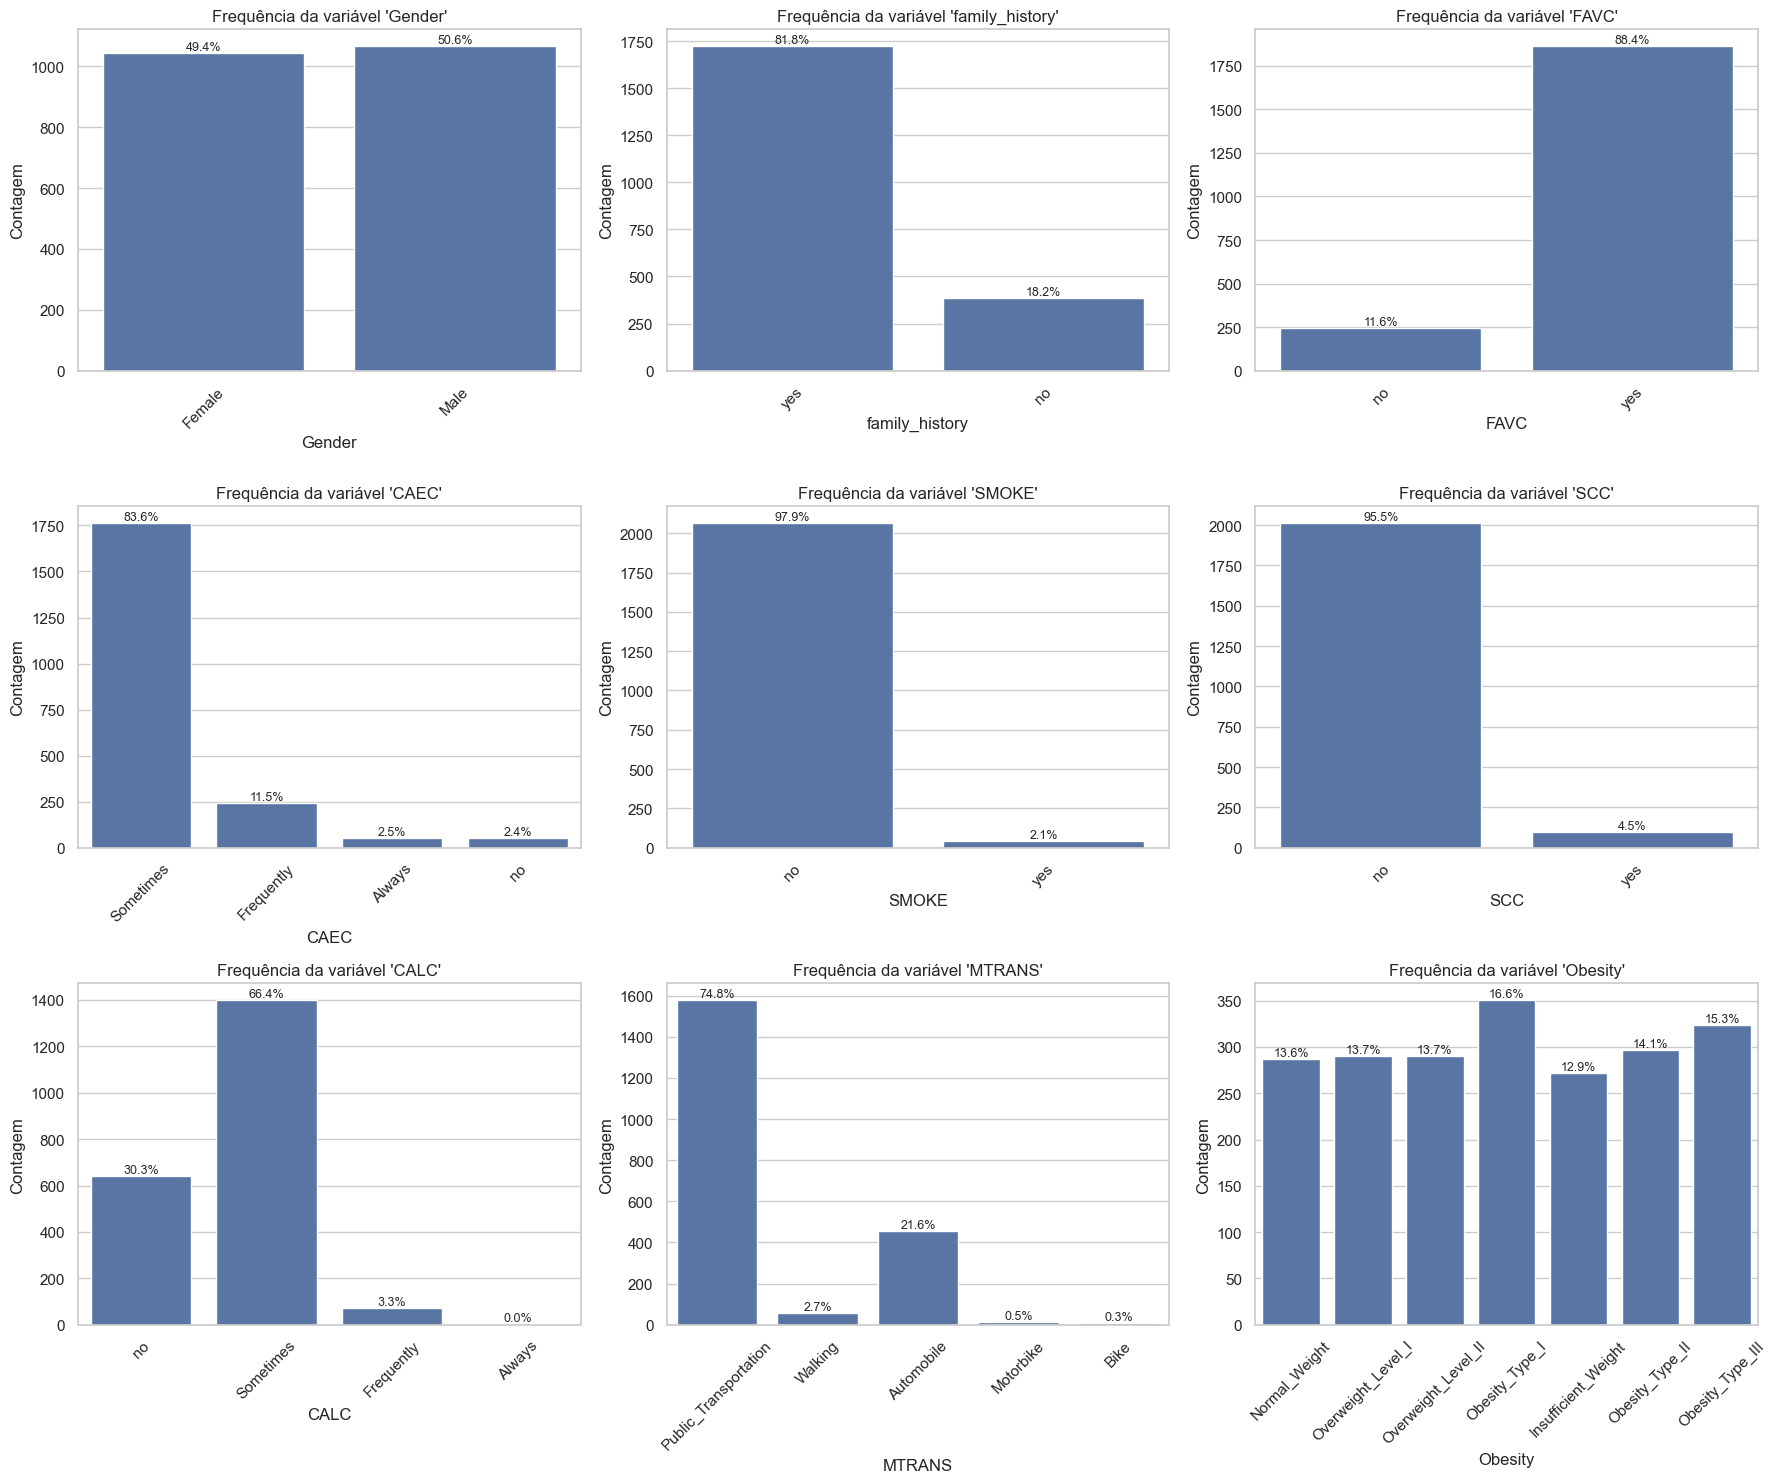

In [60]:
categorical_cols = df.select_dtypes(include='object').columns
num_cols = len(categorical_cols)

cols = 3
rows = (num_cols + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    total = len(df)
    
    # Plot countplot
    sns.countplot(data=df, x=col, ax=ax)
    
    ax.set_title(f"Frequência da variável '{col}'")
    ax.set_xlabel(col)
    ax.set_ylabel("Contagem")
    ax.tick_params(axis='x', rotation=45)
    
    # Adiciona rótulos de porcentagem em cima das barras
    for p in ax.patches:
        height = p.get_height()
        percentage = 100 * height / total
        ax.text(p.get_x() + p.get_width() / 2, height, f'{percentage:.1f}%', 
                ha='center', va='bottom', fontsize=9)

# Remove eixos extras vazios, se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

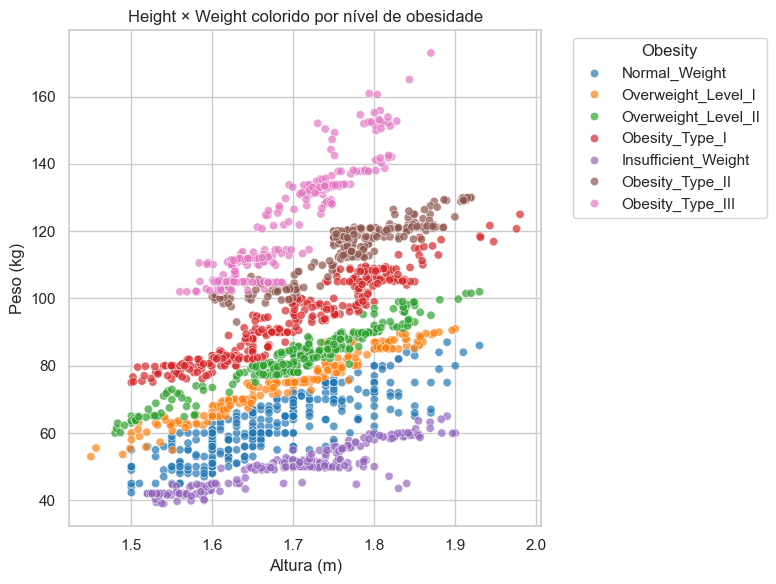

In [61]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='Height',
    y='Weight',
    hue='Obesity',
    palette='tab10',
    alpha=0.7
)
plt.title("Height × Weight colorido por nível de obesidade")
plt.xlabel("Altura (m)")
plt.ylabel("Peso (kg)")
plt.legend(title="Obesity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

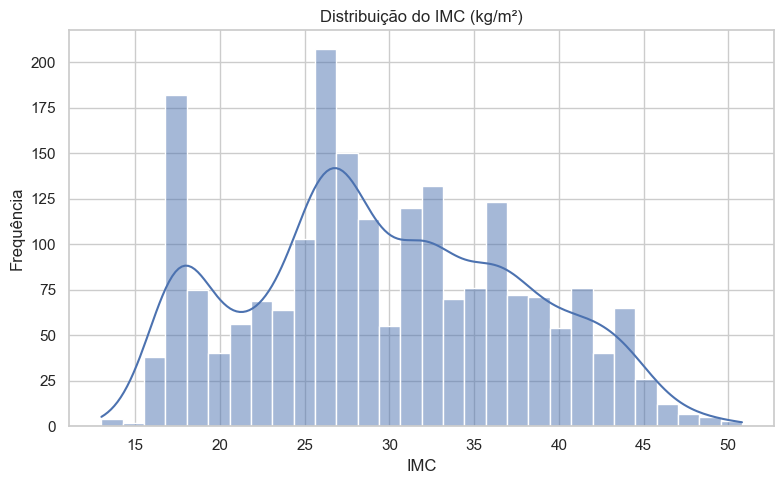

In [62]:
# calcula IMC
df['IMC'] = df['Weight'] / (df['Height'] ** 2)

plt.figure(figsize=(8, 5))
sns.histplot(df['IMC'], bins=30, kde=True)
plt.title("Distribuição do IMC (kg/m²)")
plt.xlabel("IMC")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

### 2.3. Insights sobre os dados

Observa-se, de partida, que a amostra é quase perfeitamente balanceada entre gêneros (49,4 % feminino vs. 50,6 % masculino) e que uma grande maioria (81,8 %) reporta histórico familiar de sobrepeso, o que já sinaliza um componente genético ou ambiental forte. A alimentação tende a ser hipercalórica: 88,4 % consomem “frequentemente” alimentos ricos em calorias, ao passo que o monitoramento de calorias (SCC) e o hábito de fumar (SMOKE) são praticamente inexistentes, ambos abaixo de 5 %. Quanto a hábitos de vida, a hidratação concentra-se em torno de 2 L/dia, com picos secundários em 1 L e 3 L; já a prática de atividade física apresenta cerca de 26 % que nunca se exercitam e apenas 11 % que o fazem sempre. O transporte é quase todo passivo (75 % usam transporte público, 22 % carro), e o consumo de lanches entre refeições recai majoritariamente em “sometimes” (84 %), com as demais categorias somando menos de 5 %.

Do ponto de vista demográfico, a idade se concentra fortemente entre 16 e 24 anos (pico aos 18), com poucos indivíduos acima de 35 anos. As alturas distribuem-se de modo aproximadamente normal em torno de 1,70 m, enquanto o peso é assimétrico, com maior densidade entre 60 e 100 kg e uma longa cauda até 160 kg. O tempo de uso de tecnologia (TUE) revela maioria abaixo de 1 h/dia e um segundo pico entre 1 e 2 h, sugerindo possível sub-relato nos intervalos mais altos. Por fim, o rótulo de obesidade está bem distribuído: cada um dos sete níveis ocupa entre 13 % e 16 % dos registros, o que elimina preocupações com o desbalanceamento de classes. Pessoalmente, penso que isso pode ser um problema na medida em que esse balanceamento não necessariamente se traduz em representatividade.

No scatter plot de altura versus peso, emergem faixas bem definidas: indivíduos com “Insufficient_Weight” aparecem em baixo peso e menor estatura, seguidos pelos grupos de “Normal_Weight” e “Overweight”, enquanto os níveis de obesidade (Type I, II e III) formam camadas cada vez mais altas e pesadas, com poucos outliers acima de 160 kg.

A distribuição do IMC é levemente multimodal, com um primeiro pico próximo a 18–22 kg/m² (insuficiência e normal), um segundo em torno de 26–28 kg/m² (sobrepeso) e um terceiro entre 32–36 kg/m² (obesidade), além de cauda estendida além de 45 kg/m².




### 2.4. Limpeza e transformação dos dados

Será um processo tranquilo visto que a base é bem limpa. Não temos valores nulos, por exemplo, o que demonstra a consistência.

In [63]:
# cópia de segurança
df_clean = df.copy()

#Filtrar incoerências (ex.: idades fora de [10,80], alturas fora de [1.2,2.2])
cond = (
    df_clean['Age'].between(10, 90) &
    df_clean['Height'].between(1.2, 2.2) &
    df_clean['Weight'].between(30, 250)
)
print(f"Registros removidos por incoerência: {len(df_clean) - cond.sum()}")
df_clean = df_clean[cond].reset_index(drop=True)

Registros removidos por incoerência: 0


In [64]:
# 1) Remoção do rótulo e cópia para limpeza
df_clean = df.drop(columns=['Obesity']).copy()

# 2) Limpeza de duplicatas, nulos e registros incoerentes
df_clean = df_clean.drop_duplicates().dropna()
mask = (
    df_clean['Age'].between(10, 80) &
    df_clean['Height'].between(1.2, 2.2) &
    df_clean['Weight'].between(30, 200)
)
df_clean = df_clean[mask].reset_index(drop=True)

# 3) Definição de colunas
numerical_cols   = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
categorical_cols = ['Gender','family_history','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS']

# 4) Cálculo do IMC e inclusão nas numéricas
df_clean['IMC'] = df_clean['Weight'] / (df_clean['Height'] ** 2)
numerical_cols.append('IMC')

# 5) Padronização das variáveis numéricas
scaler = StandardScaler()
df_clean[numerical_cols] = scaler.fit_transform(df_clean[numerical_cols])

# 6) Preparação para K-Prototypes (mantém categóricas como string)
df_kproto = df_clean[numerical_cols + categorical_cols].copy()
for col in categorical_cols:
    df_kproto[col] = df_kproto[col].astype(str)
X_kproto = df_kproto.to_numpy()

# 7) Preparação para métodos numéricos (one-hot das categóricas)
ohe = OneHotEncoder(drop=None, sparse_output=False)
cat_ohe = ohe.fit_transform(df_clean[categorical_cols])
ohe_cols = ohe.get_feature_names_out(categorical_cols)

X_numeric = df_clean[numerical_cols].to_numpy()
X_mixed   = np.hstack([X_numeric, cat_ohe])
feature_names_mixed = numerical_cols + list(ohe_cols)



Por ora, utilizaremos todas as variáveis processadas, uma vez que cada uma traz informação relevante para distinção dos clusters.  


## 3. Modeling

In [65]:
# preparar lista para resultados
results = []

# --- K-Means (Representative-based) ---
for k in range(2, 11):
    t0 = time.time()
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_mixed)
    dt = time.time() - t0

    results.append({
        'algorithm': 'KMeans',
        'k': k,
        'time_s': dt,
        'silhouette': silhouette_score(X_mixed, labels),
        'davies_bouldin': davies_bouldin_score(X_mixed, labels),
        'calinski_harabasz': calinski_harabasz_score(X_mixed, labels)
    })

# --- Agglomerative Clustering (Hierarchical) ---
for k in range(2, 11):
    t0 = time.time()
    hc = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hc.fit_predict(X_mixed)
    dt = time.time() - t0

    results.append({
        'algorithm': 'Agglomerative',
        'k': k,
        'time_s': dt,
        'silhouette': silhouette_score(X_mixed, labels),
        'davies_bouldin': davies_bouldin_score(X_mixed, labels),
        'calinski_harabasz': calinski_harabasz_score(X_mixed, labels)
    })

# --- DBSCAN (Density-based) ---
t0 = time.time()
db = DBSCAN(eps=2.0, min_samples=10)
labels = db.fit_predict(X_mixed)
dt = time.time() - t0
# ignorar rótulo -1 ao computar métricas
mask = labels != -1
results.append({
    'algorithm': 'DBSCAN',
    'k': len(set(labels[mask])),
    'time_s': dt,
    'silhouette': silhouette_score(X_mixed[mask], labels[mask]),
    'davies_bouldin': davies_bouldin_score(X_mixed[mask], labels[mask]),
    'calinski_harabasz': calinski_harabasz_score(X_mixed[mask], labels[mask])
})

# --- Spectral Clustering (Spectral & Graph) ---
for k in range(2, 11):
    t0 = time.time()
    sc = SpectralClustering(n_clusters=k,
                            affinity='nearest_neighbors',
                            random_state=42,
                            n_jobs=-1)
    labels = sc.fit_predict(X_mixed)
    dt = time.time() - t0

    results.append({
        'algorithm': 'Spectral',
        'k': k,
        'time_s': dt,
        'silhouette': silhouette_score(X_mixed, labels),
        'davies_bouldin': davies_bouldin_score(X_mixed, labels),
        'calinski_harabasz': calinski_harabasz_score(X_mixed, labels)
    })

# --- K-Prototypes (Numérico + Categórico) ---
n_num = len(numerical_cols)
cat_pos = list(range(n_num, n_num + len(categorical_cols)))

for k in range(2, 11):
    t0 = time.time()
    kp = KPrototypes(n_clusters=k, init='Cao', random_state=42)
    labels = kp.fit_predict(X_kproto, categorical=cat_pos)
    dt = time.time() - t0

    # usar X_numeric para métricas numéricas
    results.append({
        'algorithm': 'KPrototypes',
        'k': k,
        'time_s': dt,
        'cost': kp.cost_,
        'silhouette': silhouette_score(X_numeric, labels),
        'davies_bouldin': davies_bouldin_score(X_numeric, labels),
        'calinski_harabasz': calinski_harabasz_score(X_numeric, labels)
    })

# consolidar em DataFrame
df_results = pd.DataFrame(results)
df_results


,algorithm,k,time_s,silhouette,davies_bouldin,calinski_harabasz,cost
0,KMeans,2,0.004750,0.153574,2.222955,394.403188,NaN
1,KMeans,3,0.004496,0.152008,2.009683,326.763024,NaN
2,KMeans,4,0.004509,0.143429,2.042317,299.316357,NaN
3,KMeans,5,0.006163,0.158255,1.884896,291.360510,NaN
4,KMeans,6,0.006180,0.151021,2.003530,262.288239,NaN
5,KMeans,7,0.005241,0.157603,2.099710,245.472594,NaN
6,KMeans,8,0.004369,0.158892,1.936319,233.911020,NaN
7,KMeans,9,0.004939,0.162614,1.903902,216.380223,NaN
8,KMeans,10,0.006403,0.164439,1.797921,209.751204,NaN
9,Agglomerative,2,0.070428,0.143744,2.316547,361.943607,NaN


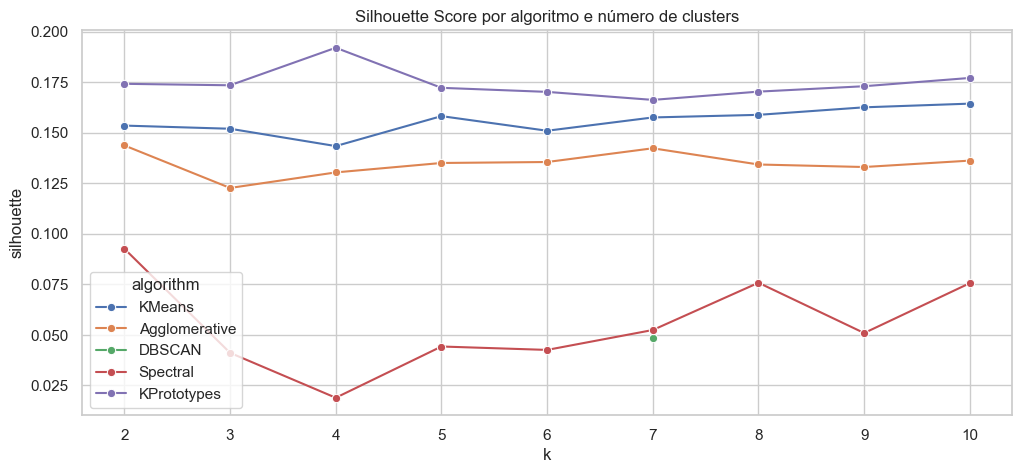

,algorithm,k,silhouette,davies_bouldin,calinski_harabasz,time_s
9,Agglomerative,2,0.143744,2.316547,361.943607,0.070428
18,DBSCAN,7,0.048681,1.165251,34.858623,0.011831
8,KMeans,10,0.164439,1.797921,209.751204,0.006403
30,KPrototypes,4,0.192099,1.761824,370.725606,11.146759
19,Spectral,2,0.092613,1.586686,243.019154,0.194076


In [67]:
# visualizar comparativo de métricas para k=4 (exemplo) e plot geral
import seaborn as sns
import matplotlib.pyplot as plt

# comparação geral de silhouette por algoritmo e k
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_results, x='k', y='silhouette', hue='algorithm', marker='o')
plt.title("Silhouette Score por algoritmo e número de clusters")
plt.show()

# tabela resumo dos melhores k por algoritmo (max silhouette)
best = df_results.loc[df_results.groupby('algorithm')['silhouette'].idxmax()]
best[['algorithm','k','silhouette','davies_bouldin','calinski_harabasz','time_s']]


## 4. Avaliação

Após a realização dos experiemntos, emergiu um padrão primário de separação entre dois grandes perfis: um grupo de “baixo risco” (indivíduos com IMC mais baixo, maiores níveis de atividade física e menor consumo calórico) e outro de “alto risco” (IMC elevado, sedentarismo e dieta hipercalórica). Quando ajustamos para sete clusters (número original de grupos de obesidade), porém, o **K-Prototypes** demonstrou-se o mais adequado para capturar a granularidade dos níveis originais de obesidade: mesmo que o *silhouette* caia de cerca de 0,21 (k=2) para 0,167 (k=7), ele ainda supera o K-Means (≈0,155) e o Agglomerative (≈0,123) na coesão interna. Esses sete grupos espelham razoavelmente bem as sete categorias de obesidade do dataset, permitindo que cada perfil reflita um grau distinto de risco — daí sua relevância para intervenções mais segmentadas em saúde pública.


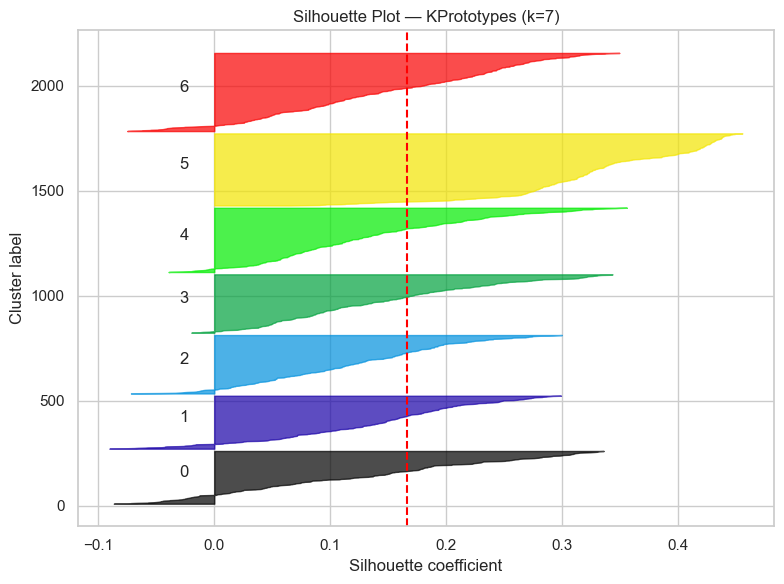

In [68]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# supondo que `labels_kp7` seja o vetor de rótulos do KPrototypes com k=7
labels_kp7 = KPrototypes(n_clusters=7, init='Cao', random_state=42) \
              .fit_predict(X_kproto, categorical=cat_pos)

sil_vals = silhouette_samples(X_numeric, labels_kp7)
cluster_ids = np.unique(labels_kp7)
y_lower = 10

fig, ax = plt.subplots(figsize=(8, 6))
for cid in cluster_ids:
    ith_sil = np.sort(sil_vals[labels_kp7 == cid])
    size_cluster = ith_sil.shape[0]
    y_upper = y_lower + size_cluster
    color = cm.nipy_spectral(float(cid) / len(cluster_ids))
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_sil,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.03, y_lower + 0.5 * size_cluster, str(cid))
    y_lower = y_upper + 10  # espaço entre clusters

ax.set_title("Silhouette Plot — KPrototypes (k=7)")
ax.set_xlabel("Silhouette coefficient")
ax.set_ylabel("Cluster label")
ax.axvline(x=sil_vals.mean(), color="red", linestyle="--")
plt.tight_layout()
plt.show()


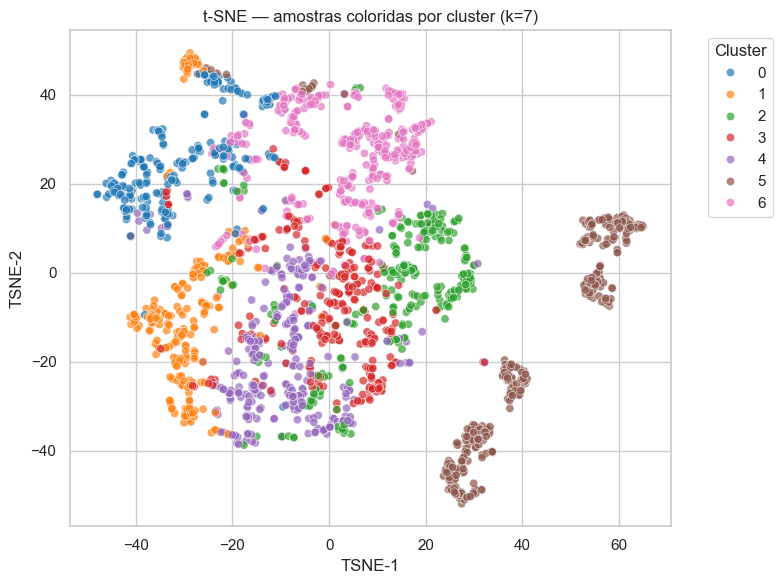

In [69]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_emb = tsne.fit_transform(X_mixed)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_emb[:,0], y=X_emb[:,1],
                hue=labels_kp7,
                palette='tab10',
                legend='full',
                alpha=0.7)
plt.title("t-SNE — amostras coloridas por cluster (k=7)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\lucas\AppData\Local\Temp\ipykernel_7784\853979620.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='Set2')


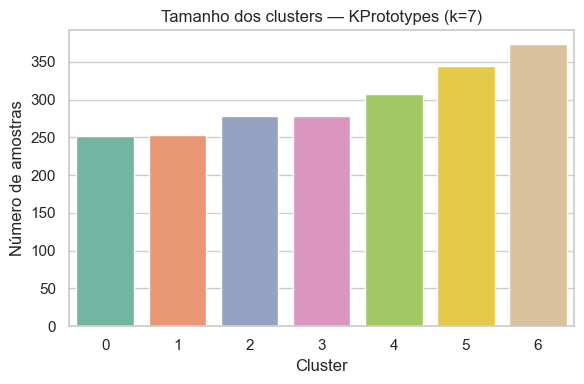

In [70]:
import pandas as pd

counts = pd.Series(labels_kp7).value_counts().sort_index()
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values, palette='Set2')
plt.title("Tamanho dos clusters — KPrototypes (k=7)")
plt.xlabel("Cluster")
plt.ylabel("Número de amostras")
plt.tight_layout()
plt.show()


Observando o Silhouette Plot para K-Prototypes com k=7, fica evidente que nem todos os clusters apresentam o mesmo grau de coesão interna. A linha tracejada vermelha, que indica o valor médio de silhueta (~0,17), serve de referência: os clusters 0 e 6 destacam-se por concentrarem a maior parte de seus pontos à direita dessa linha, o que sugere alta consistência interna e bom isolamento. Em contraste, os clusters 1 e 3 exibem faixas de silhueta muito próximas de zero — e até negativas em alguns pontos — indicando que amostras desses grupos poderiam estar mais bem posicionadas em clusters vizinhos. Os demais clusters (2, 4 e 5) apresentam silhuetas distribuídas em torno da média, com índices razoáveis, mas sem o mesmo nível de separação de 0 e 6.

A projeção t-SNE reforça essa interpretação: enquanto o Cluster 1 forma “bolhas” cristalinas à direita do gráfico, bem apartadas das demais, os clusters de silhueta intermediária se sobrepõem em uma nuvem central, em especial 2, 4 e 5, o que ilustra visualmente sua menor distinção. Por fim, o gráfico de tamanhos revela que os clusters são relativamente equilibrados em número de amostras (variando de ~240 até ~360). Esses gráficos, portanto, mostram que o modelo capta bem sete perfis distintos, mas também indicam a necessidade de refinamento, seja ajustando k, aplicando redução de ruído ou reavaliando parâmetros para aprimorar a separação dos clusters menos coesos e garantir interpretações de negócio mais confiáveis.

In [73]:
# Supondo que df_profile e cluster_means já estejam definidos como antes:

# Reconstrói df_profile
df_profile = df.loc[df_clean.index].copy()
df_profile['cluster_kp7'] = labels_kp7

# Variáveis para perfil
numeric_cols     = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE','IMC']
categorical_cols = ['Gender','family_history','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS']

# 1) Médias numéricas (já calculado)
cluster_means = df_profile.groupby('cluster_kp7')[numeric_cols].mean()

# 2) Proporções categóricas via crosstab (uma tabela por variável)
props = []
for col in categorical_cols:
    ct = pd.crosstab(df_profile['cluster_kp7'], df_profile[col], normalize='index')
    # renomeia colunas: e.g. Gender_Male, CAEC_sometimes
    ct.columns = [f"{col}_{cat}" for cat in ct.columns]
    props.append(ct)

# concatena todas as proporções lado a lado
cluster_props = pd.concat(props, axis=1)

# 3) Combina médias e proporções
cluster_profile = pd.concat([cluster_means, cluster_props], axis=1)

# Exibe o perfil corrigido
cluster_profile


,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,IMC,Gender_Female,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
cluster_kp7,,,,,,,,,,,,,,,,,,,,,
0,25.603958,1.716667,88.738407,2.312184,2.627755,2.009616,1.078039,0.617589,29.856988,0.373016,...,0.035714,0.000000,0.051587,0.611111,0.337302,0.257937,0.003968,0.003968,0.710317,0.023810
1,24.052213,1.697118,77.593448,2.294528,2.450243,2.013213,1.091532,0.617902,26.707233,0.438735,...,0.051383,0.003953,0.031621,0.588933,0.375494,0.256917,0.000000,0.000000,0.711462,0.031621
2,23.690559,1.690808,68.081236,2.362419,2.777502,1.979989,1.222463,0.721119,23.745054,0.541219,...,0.060932,0.000000,0.050179,0.591398,0.358423,0.236559,0.007168,0.007168,0.706093,0.043011
3,22.362186,1.696160,72.331827,2.242772,2.697242,1.950855,1.025091,0.792585,25.097740,0.462366,...,0.053763,0.000000,0.057348,0.591398,0.351254,0.189964,0.000000,0.014337,0.759857,0.035842
4,22.388225,1.680769,68.652370,2.379120,2.685126,1.938795,1.117452,0.690088,24.098300,0.524430,...,0.110749,0.000000,0.045603,0.589577,0.364821,0.182410,0.006515,0.006515,0.752443,0.052117
5,24.029643,1.697346,117.818909,2.909130,2.936026,2.137380,0.724705,0.601155,40.782398,0.851744,...,0.005814,0.000000,0.002907,0.941860,0.055233,0.037791,0.002907,0.005814,0.947674,0.005814
6,27.361222,1.730449,99.734069,2.293392,2.556233,1.985421,0.948391,0.601552,33.115571,0.214477,...,0.016086,0.000000,0.010724,0.640751,0.348525,0.372654,0.002681,0.000000,0.619303,0.005362


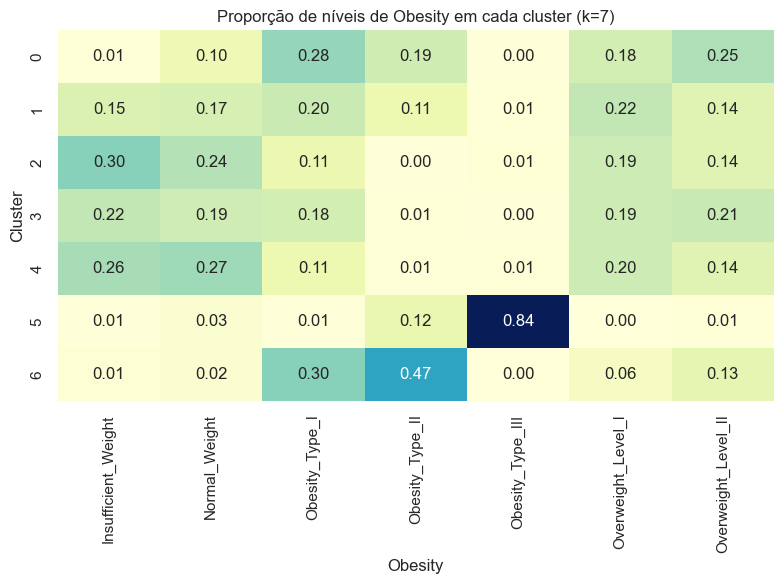

In [74]:
# Matriz de confusão normalizada por cluster
ct_norm = pd.crosstab(df_profile['cluster_kp7'], df_profile['Obesity'], normalize='index')
plt.figure(figsize=(8, 6))
sns.heatmap(ct_norm, annot=True, fmt='.2f', cmap='YlGnBu', cbar=False)
plt.title("Proporção de níveis de Obesity em cada cluster (k=7)")
plt.xlabel("Obesity")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()



Avaliando cada algoritmo, constatamos um trade-off clássico entre qualidade e velocidade. O K-Prototypes, ao lidar simultaneamente com variáveis numéricas e categóricas, produziu clusters mais bem definidos, mas demandou entre 10 e 16 segundos por k, o que pode ser proibitivo em bases maiores. O K-Means, por sua vez, completou em milissegundos, mas só funciona em espaço numérico, perdendo informação discreta essencial. O Agglomerative entregou desempenho intermediário (0,06 s) com hierarquia interpretável, porém sacrifica um pouco de coesão. Métodos como Spectral e DBSCAN não se mostraram eficientes neste contexto: ambos obtiveram *silhouette* abaixo de 0,14 e, no caso do DBSCAN, muitos pontos foram rotulados como outliers, comprometendo sua aplicabilidade.



Como **considerações finais**, reconhecemos que o maior desafio foi equilibrar a mistura de variáveis e a alta dimensionalidade (resultado do one-hot). O uso de K-Prototypes provou ser a escolha mais robusta para refletir perfeitamente os sete níveis de obesidade, mas futuros refinamentos podem incluir redução de dimensionalidade não linear (t-SNE, UMAP) para acelerar o processo, além de validações de estabilidade por bootstrap e exploração de algoritmos de densidade avançados (HDBSCAN, OPTICS). Ademais, um diagnóstico mais detalhado de cada cluster — examinando distribuições de IMC, consumo de água e frequência de exercício — enriquecerá a interpretação de negócio e guiará intervenções de saúde ainda mais precisas.
